In [30]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image


# jupyter theme overrides
from jupyterthemes import jtplot
# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='chesterish')
# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

plt.rcParams['image.cmap'] = 'jet'
# recet to matplotlib standards
#jtplot.reset()

# 2. Time Series Basics

A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data. - <a href="https://en.wikipedia.org/wiki/Time_series">Wikipedia</a>

## 2.1 Data generating process

A time series is a sequence of observations $y_1, \dots, y_T$ which are equally spaced along a time axis according to a frequency of observation (e.g. daily, monthly, yearly, etc). 

An observed time series, denoted $\{y_t\}_{t=1}^{T}$, is assumed to stem from an unobservable <strong>data generating process</strong>.

A parametric modelling approach to time series analysis makes the fundamental assumption that the underlying data generating process is a <strong>stationary stochastic process</strong>. That is, the process has a certain structure which can be described by using a number of parameters (e.g autoregressive or moving average models).

## 2.2 Concept of stationarity
A stochastic process $\{y_t\}_{t=1}^{T}$ is called strongly stationary if the distribution of $\{y_{t+s}\}_{t=1}^{T}$ for $s \in T$ is exactly the same as the distribution of $\{y_t\}_{t=1}^{T}$. In other words, the distribution of original time-series is exactly same as lagged time series (by any number of lags) or even sub segments of the time series. This assumption is to strict and absolutely not applicable to time series encountered in real life.

A milder assumption is <strong>covariance stationarity</strong>. A process $\{y_t\}_{t=1}^{T}$ is covariance stationary if:
<ol>
<li>$ E[y_t] = \mu < \infty $ for all $t$</li>
<li>$ V[y_t] = \sigma^2 < \infty $ for all $t$</li>
<li>$ \gamma(t, s) = \gamma[\tau] < \infty $ for all $t$ and $\tau$</li>
</ol>

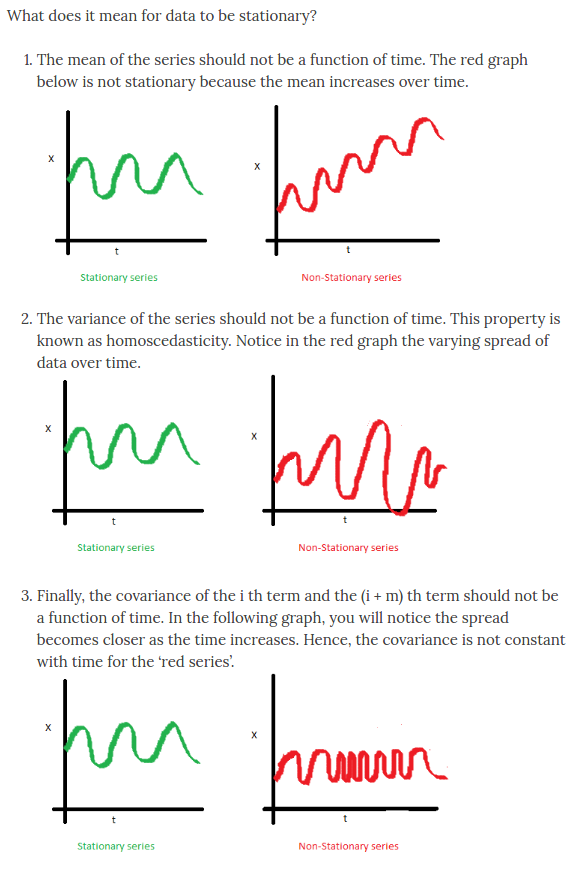

In [31]:
Image(filename=('stationarity.png'))

## 2.3 Serial Correlation (Autocorrelation)

<strong>Autocovariance</strong> describes the covariance between two values of a stochastic process $\{y_t\}_{t=1}^T$ at different points in time:

$$
\gamma(t, s) = Cov(y_t, y_s) = E[(y_t - \mu_t)(y_s - \mu_s)]
$$

Then, the <strong>autocarrelation function</strong> is given by

$$
\rho(t, s) = \frac{\gamma(t, s)}{\sigma_t\sigma_s}
$$

with $-1 < \rho(t, s) < +1$ and where $\sigma$ is the standard deviation. This is the formalization of the third requirement of a stationary time series. Thus, when the residuals (errors) in a time series are correlated with each other it is said to exhibit <strong>serial correlation</strong>. For a stationary process the covariance is only dependent on the difference $\tau$ between $t$ and $s$.

The autocorrrelation is the processes autocovariance normalized by the standard deviation. Thus, the Autocorrelation is a better measurement for the dependency structure, because the autocovariacne will be affected by the underlying units of measurement for the observation. The autocovariance in some cases will not necessarily give an indication/intuition how strong the observations are connected with each other

To get a better grasp of the serial correlation within a time series the <strong>Scatter Plot</strong> can be used. This is plotting the series against its past.

In [32]:
# import passenger data set
data = pd.read_csv('./data/passengers.csv', sep=';', header=0, parse_dates=True, index_col=0)

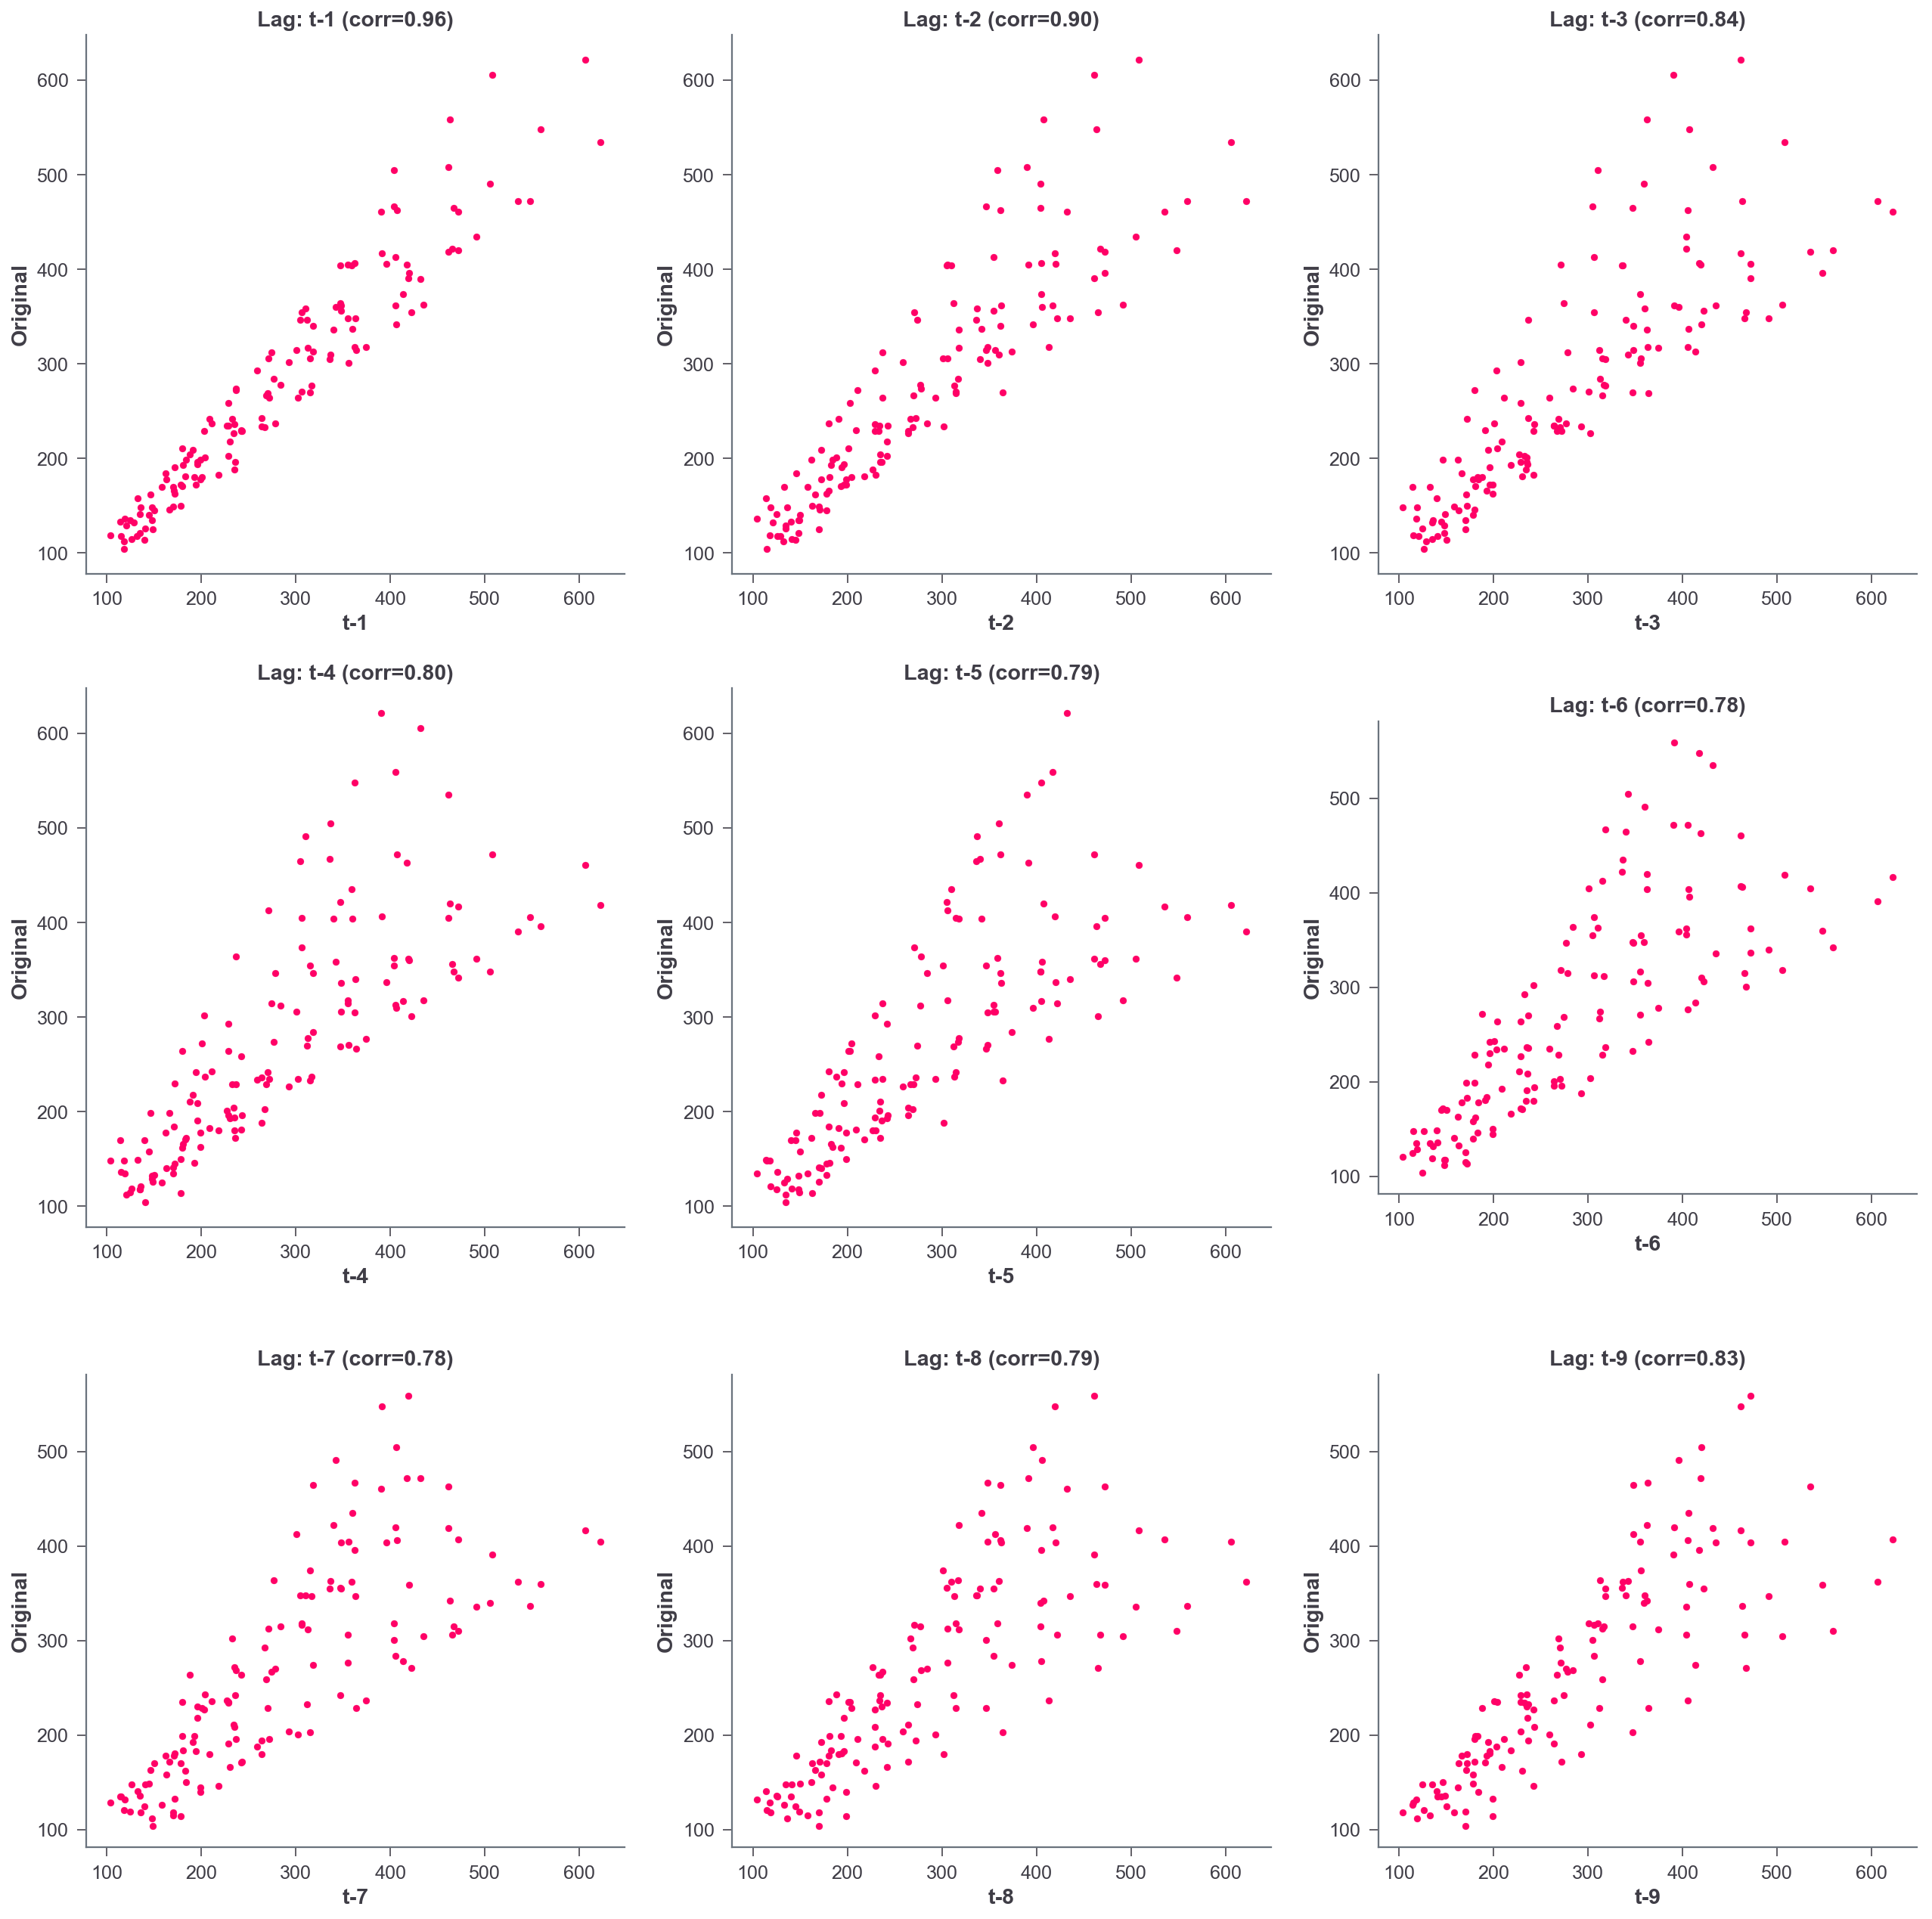

In [33]:
ncols = 3
nrows = 3
lags = 9

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6 * ncols, 6 * nrows))

for ax, lag in zip(axes.flat, np.arange(1, lags + 1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([data, data.shift(-lag)], axis=1, keys=['y']+[lag_str]).dropna())
    
    # plot data
    X.plot(ax=ax, kind='scatter', y='y', x=lag_str, color='#FF0066');
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original');
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    
    # top and right spine from plot
    sns.despine();

fig.tight_layout()
plt.savefig('./img/scatter_plot_pas.png')
plt.show()

If we fail to account for this in our models later on the standard errors of our coefficients are underestimated, inflating the size of our t-statistics. The result is too many Type-1 errors, where we reject our null hypothesis even when it is True. Ignoring autocorrelation means that the model predictions will be inaccurate, and one is likely to draw incorrect conclusions about the impact of the independent variables in our model. 

The plots of the <strong>Autocorrelation function (ACF)</strong> and the <strong>Partial Autorrelation Function (PACF)</strong> are the two main tools to examine the time series dependency structure. The ACF is a function of the time displacement of the time series itself. Informally, it is the similarity between observations as a function of the time lag between them. The PACF is the conditional correlation between two variables under the assumptions that the effects of all previous lags on the time series are known.

The <code>ts_plot</code> function will be used to quickly evaluate statistical and distributional phenomena of a given time series process. It includes the ACF, PACF, QQ plot, and a histogram visualization.

In [34]:
def ts_plot(y, lags=None, filename='', title=''):
    '''
    Calculate acf, pacf, histogram, and qq plot for a given time series
    '''
    # if time series is not a Series object, make it so
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    # initialize figure and axes
    fig = plt.figure(figsize=(14, 12))
    layout = (3, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    hist_ax = plt.subplot2grid(layout, (2, 1))
    
    # time series plot
    y.plot(ax=ts_ax)
    plt.legend(loc='best')
    ts_ax.set_title(title);
    
    # acf and pacf
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5) 
    
    # qq plot
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Normal QQ Plot')
    
    # hist plot
    y.plot(ax=hist_ax, kind='hist', bins=25);
    hist_ax.set_title('Histogram');
    plt.tight_layout();
    plt.savefig('./img/{}.png'.format(filename))
    plt.show()
    return

## 2.4 White noise

Random rocess $x_t$ is said to be a <strong>white noise process</strong> if its components each have a probability distribution with zero mean, finite variance and are statistically (serially) uncorrelated. It has the form

$$
x_t = \varepsilon_t
$$

where $\varepsilon_t \sim (0, \sigma^2)$ with $\sigma^2 < \infty$, and $E[\varepsilon_t\varepsilon_s] = 0$ for all $t /= s$.

Errors are serially uncorrelated if they are <strong>independent and identically distributed (iid)</strong>. Serially uncorrelated errors implies that the joint distribution of, say $(\varepsilon_1, \varepsilon_2)$ must be a product of the distribution of the individual components $f(\varepsilon_1, \varepsilon_2) = f(\varepsilon_1) \cdot f(\varepsilon_2)$.

This is important because if a time series model is appropriate and successful at capturing the underlying process, residuals of the model will be iid and resemble a white noise process. Therefore part of time series analysis is simply trying to fit a model to a time series such that the residual series is indistinguishable white noise.

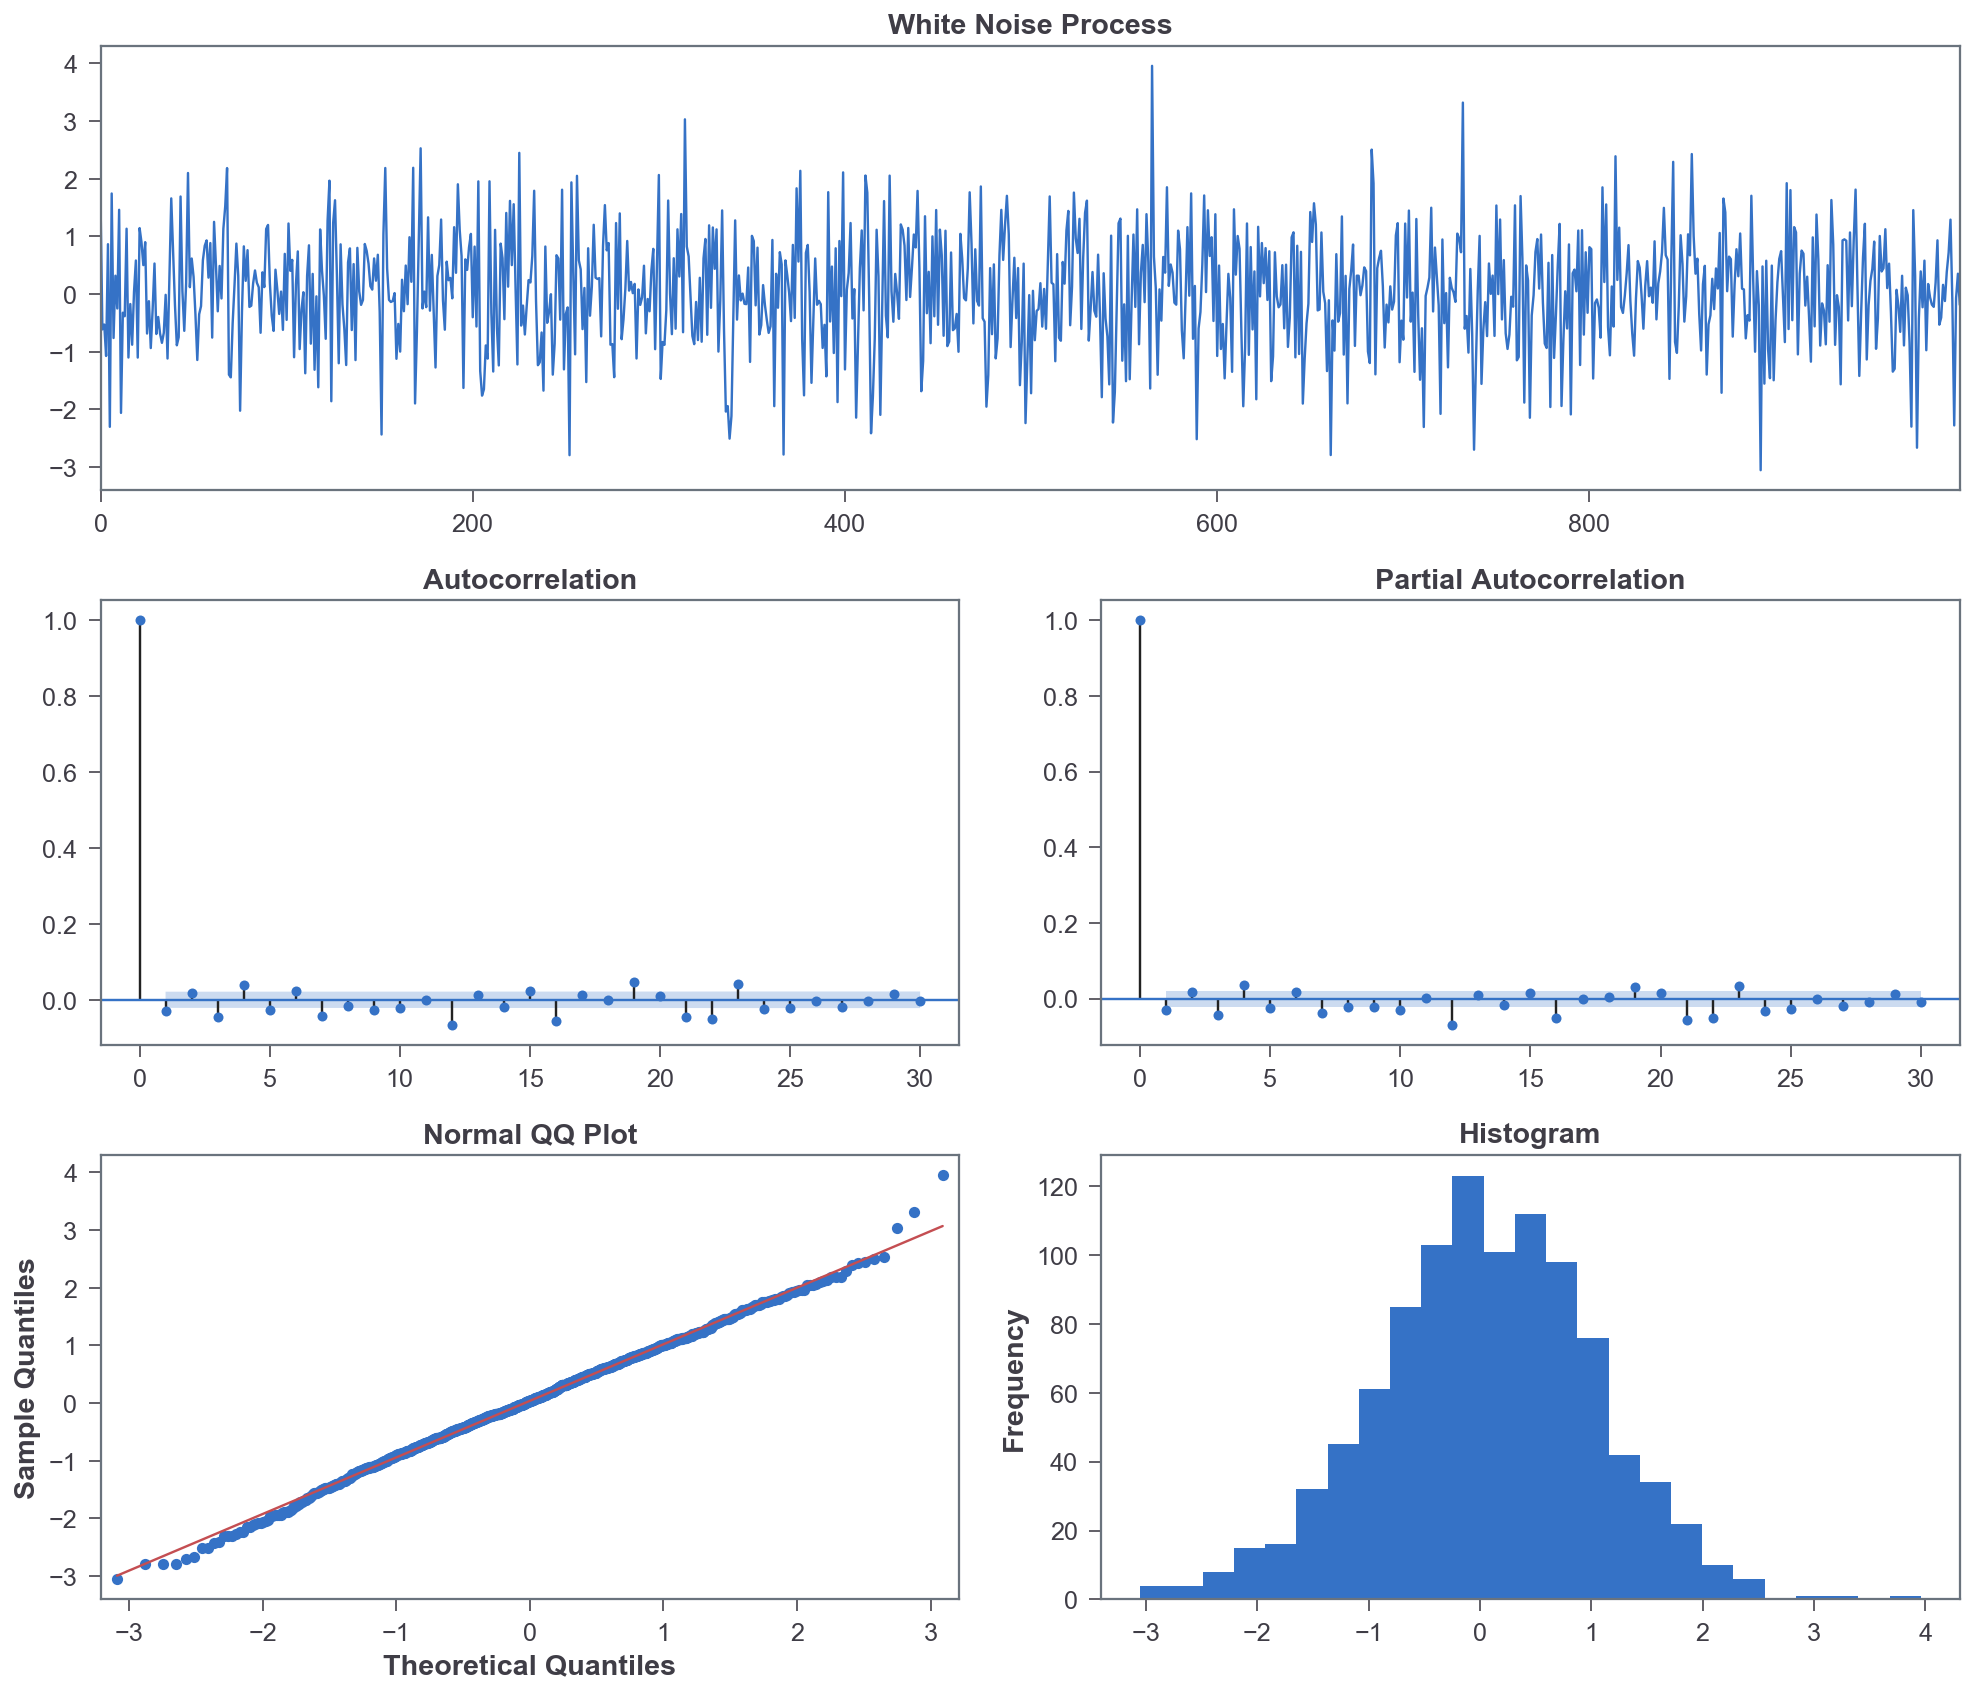

In [35]:
np.random.seed(1)

# simulate discrete Gaussian white noise N(0, 1)
e = np.random.normal(size=1000)
#e = np.random.standard_t(size=1000, df=1)
ts_plot(e, lags=30, filename='white_noise', title='White Noise Process')

The above plots resemble the desired structure of a time series errors when conducting prediction. Since a <strong>Normal distribution</strong> is assumed for the data creation. The process is thus called a Gaussian white noise process. However, most financial time series, e.g. returns on assets, are assumed to stem from a <strong>Student's t-distribution</strong>. 

From a visual point of view, as the <strong>Degrees of Freedom (DoF)</strong> of t-distribution increase it approches the normal distribution (at around <code>DoF=30</code>). The interpretation is, that for low DoF, extreme events are more likely to ocurr when compared to the normal distribution. This is referred to as <strong>leptocurtic</strong> behaviour, informally <strong>fat tails</strong> and highlight the fact that there is distributional density in the tail areas of a distribution.


## 2.5  Random walk

A process $\{x_t\}_{t=1}^T$ is called a random walk process if it is of the form

$$
x_t = x_{t-1} + \varepsilon_t
$$

where $\varepsilon_t$ is a white noise process. What is special about the random walk is, that it is <strong>non-stationary</strong>, that is, if a given time series is governed by a random walk process it is unpredictable.

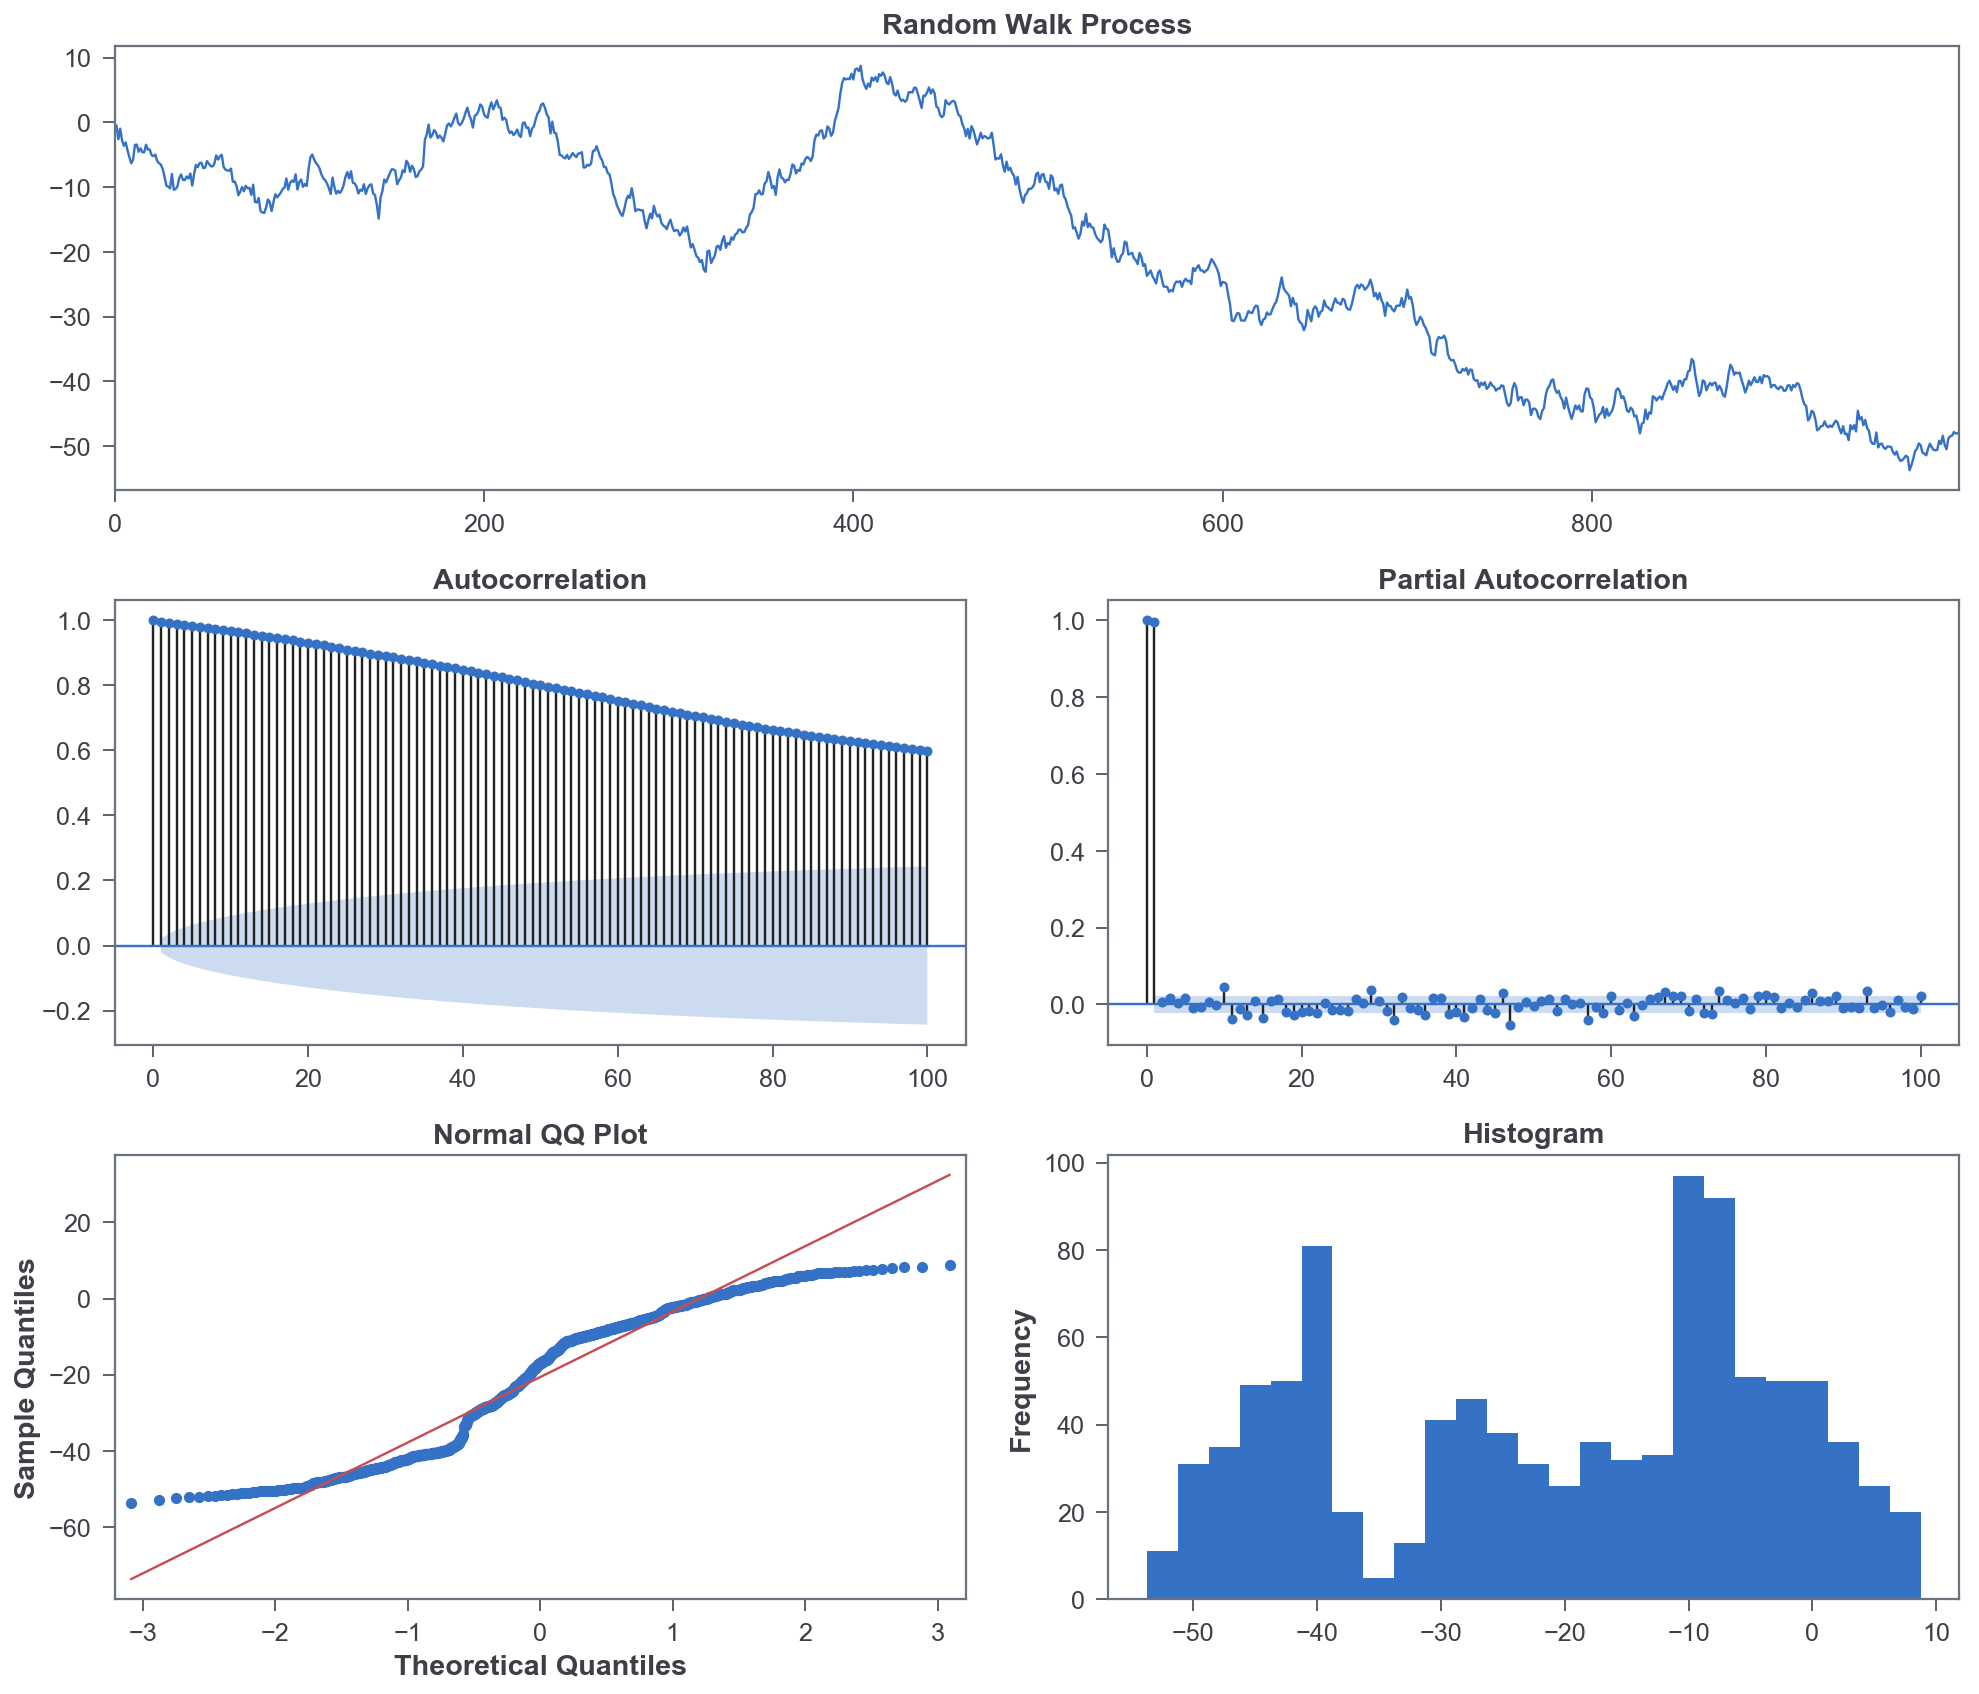

In [23]:
np.random.seed(2)

# parameter setting
T = 1000
e = np.random.normal(size=T)
x = np.zeros_like(e)

# simulate random walk
for t in range(T):
    x[t] = x[t-1] + e[t]

# plot series
ts_plot(x, lags=100, filename='random_walk', title='Random Walk Process')

<strong>Inference</strong>
<ul>
<li>Seemingly unpredictable beahviour in the data</li>
<li>High ACF for any lag length</li>
<li>The normal QQ plot and the histogram indicate that the series is not normally distributed</li>
</ul>

The random walk is a first order <strong>autoregressive process</strong> (see next section) wih a <strong>unit root</strong>, that is, the parameter $\phi = 1$. This causes the process to be non-stationary. However, the process can be made stationary by applying simple algebra

$$
x_t - x_{t-1} = \varepsilon_t
$$



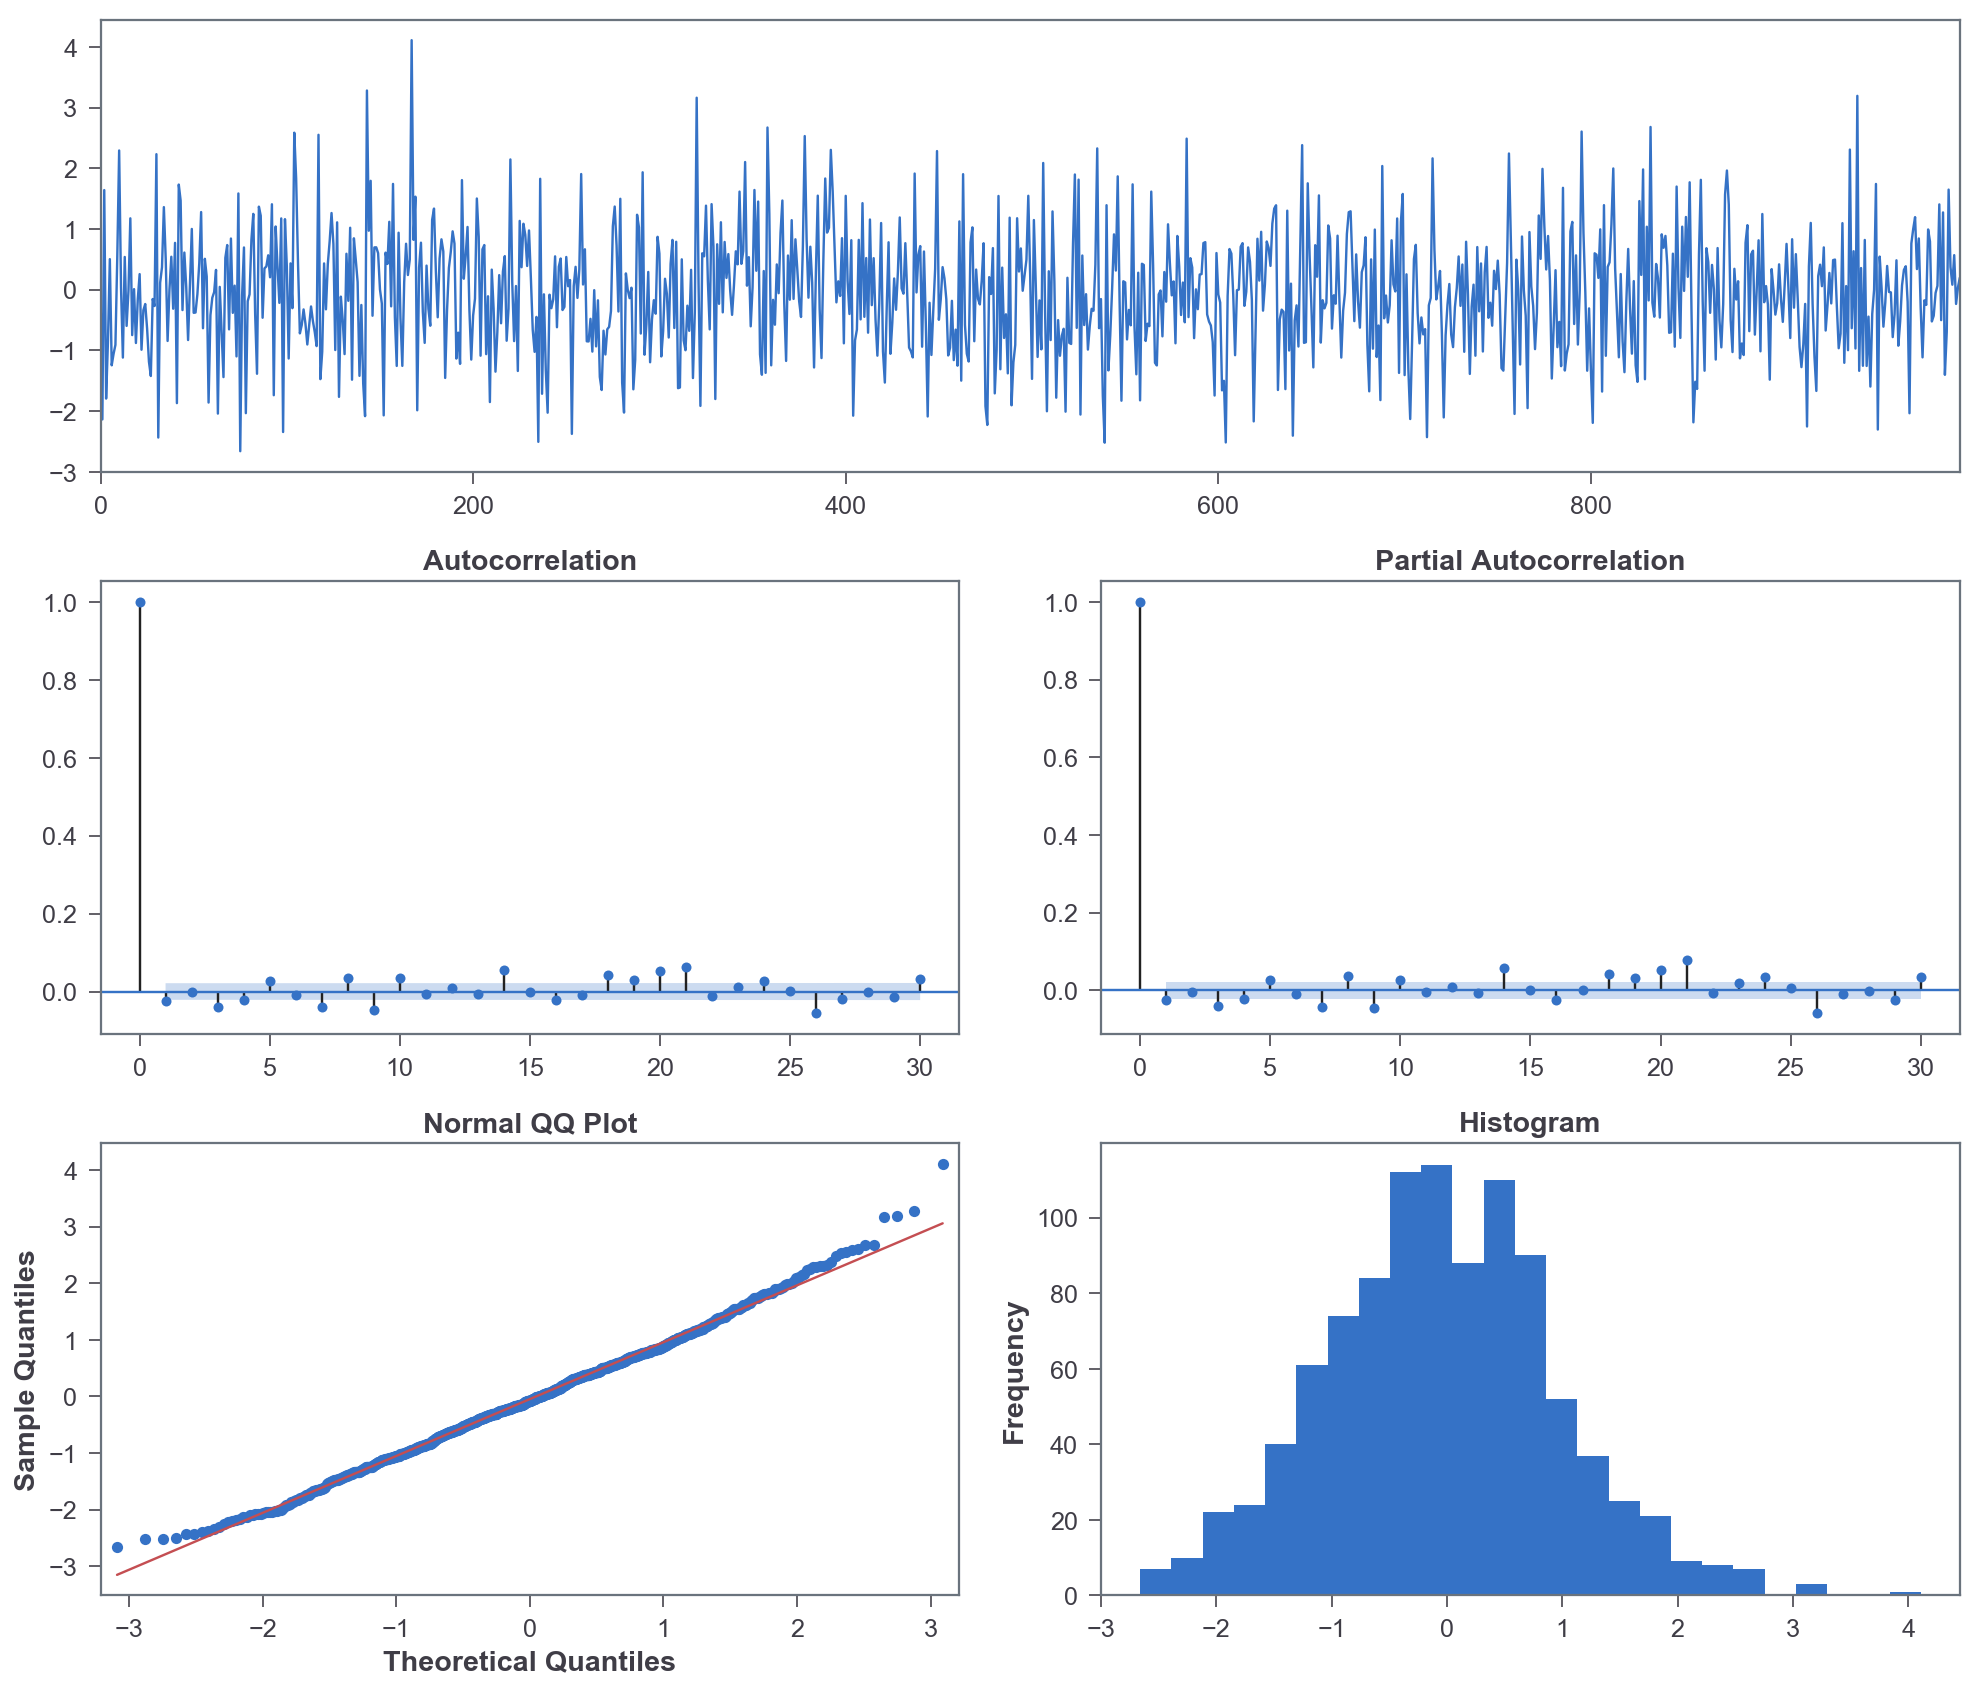

In [17]:
ts_plot(np.diff(x), lags=30)

## 2.6 The Autoregressive Model - AR(p)

As mentioned above the random walk process belongs to a more general group of processes, called </strong>autoregressive process</strong> of the form

$$
x_t = \mu + \sum_{i=1}^p\phi_p x_{t-p} + \varepsilon_t
$$

The current observation is a linear combination of past observations. For example an AR(1) time series is one period lagged weighted version of itself and is formulated as

$$
x_t = \mu + \phi x_{t-1} + \varepsilon_{t}
$$

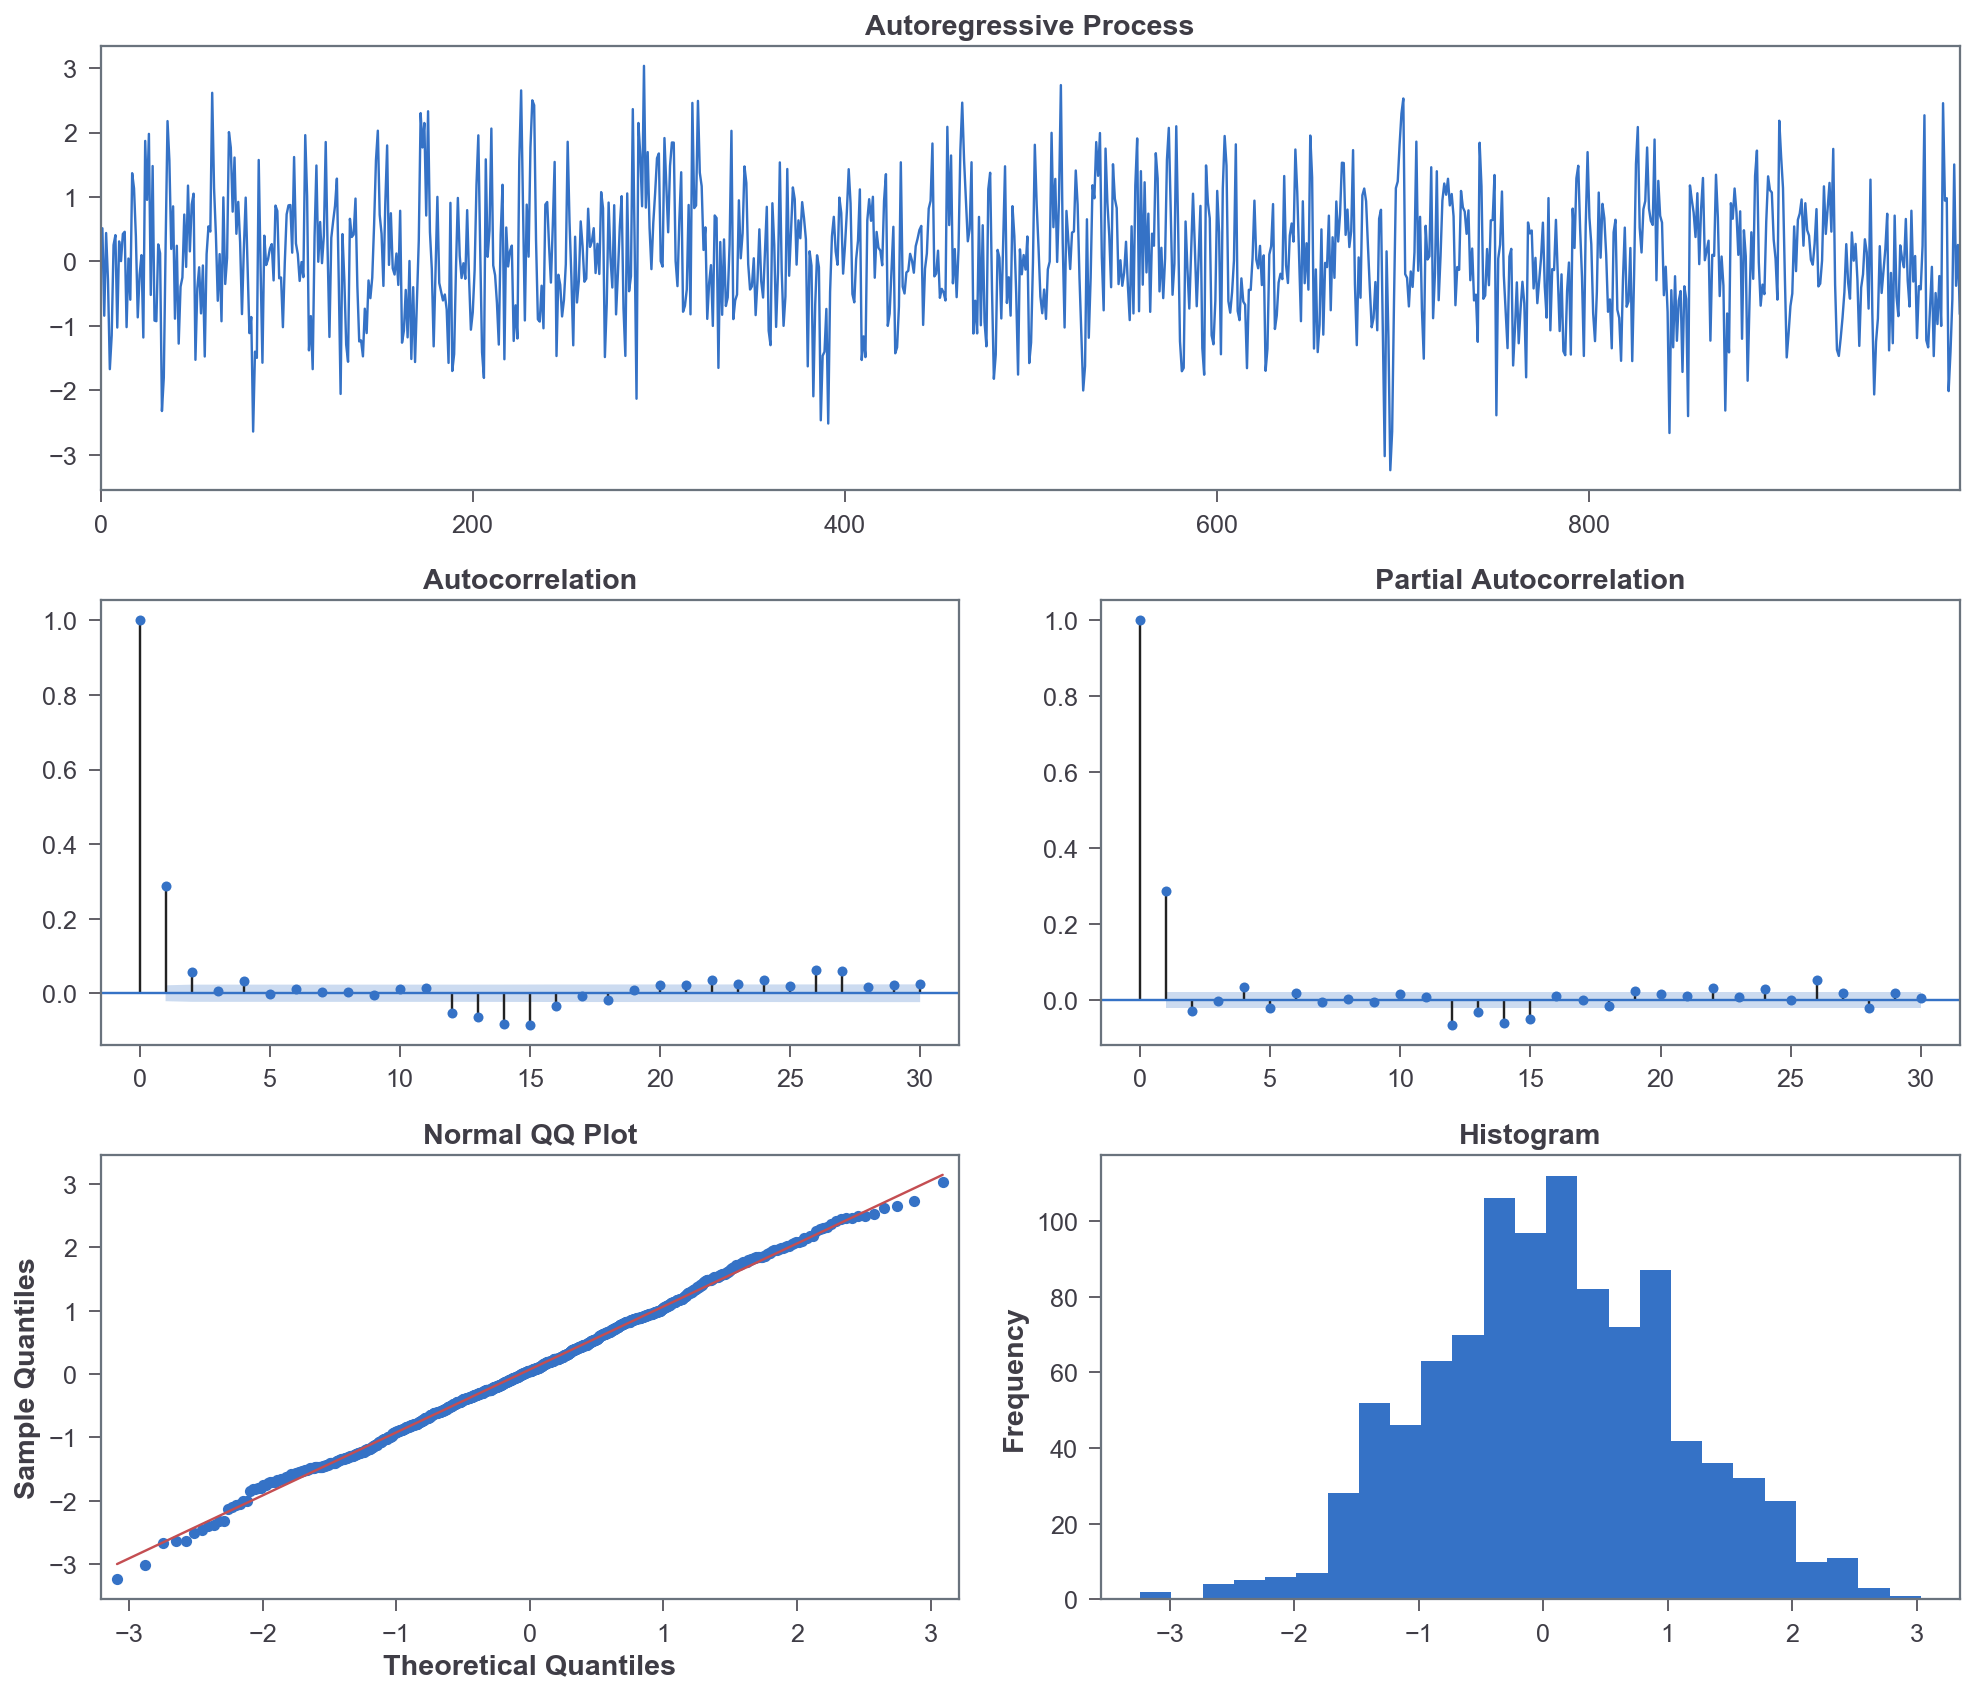

In [24]:
np.random.seed(4)

# parameter setting
T = 1000
e = np.random.normal(size=T)
x = np.zeros_like(e)
phi = 0.3

# simulate AR(1)
for t in range(T):
    x[t] = phi * x[t-1] + e[t]

    # plot series
ts_plot(x, lags=30, filename='ar1', title='Autoregressive Process')

<strong>Inference</strong>
<ul>
<li>ACF and PACF show spikes for the first lag order</li>
<li>Histogram and QQ plot indicate nearly random error terms</li>
</ul>


## 2.7 The Moving Average Model - MA(q)

The <strong>moving average model MA(q)</strong> assumes that the observed time series can be represented by a linear combination of white noise error terms. It has the general form

$$
x_t = \varepsilon_t + \sum_{i=1}^q\theta_q\varepsilon_{t-q}
$$

If $q < \infty$ the time series will always be stationary. For example a MA(2) process could look like this

$$
x_t = \varepsilon_t + 0.8 \varepsilon_{t-1} -1.4 \varepsilon_{t-2}
$$

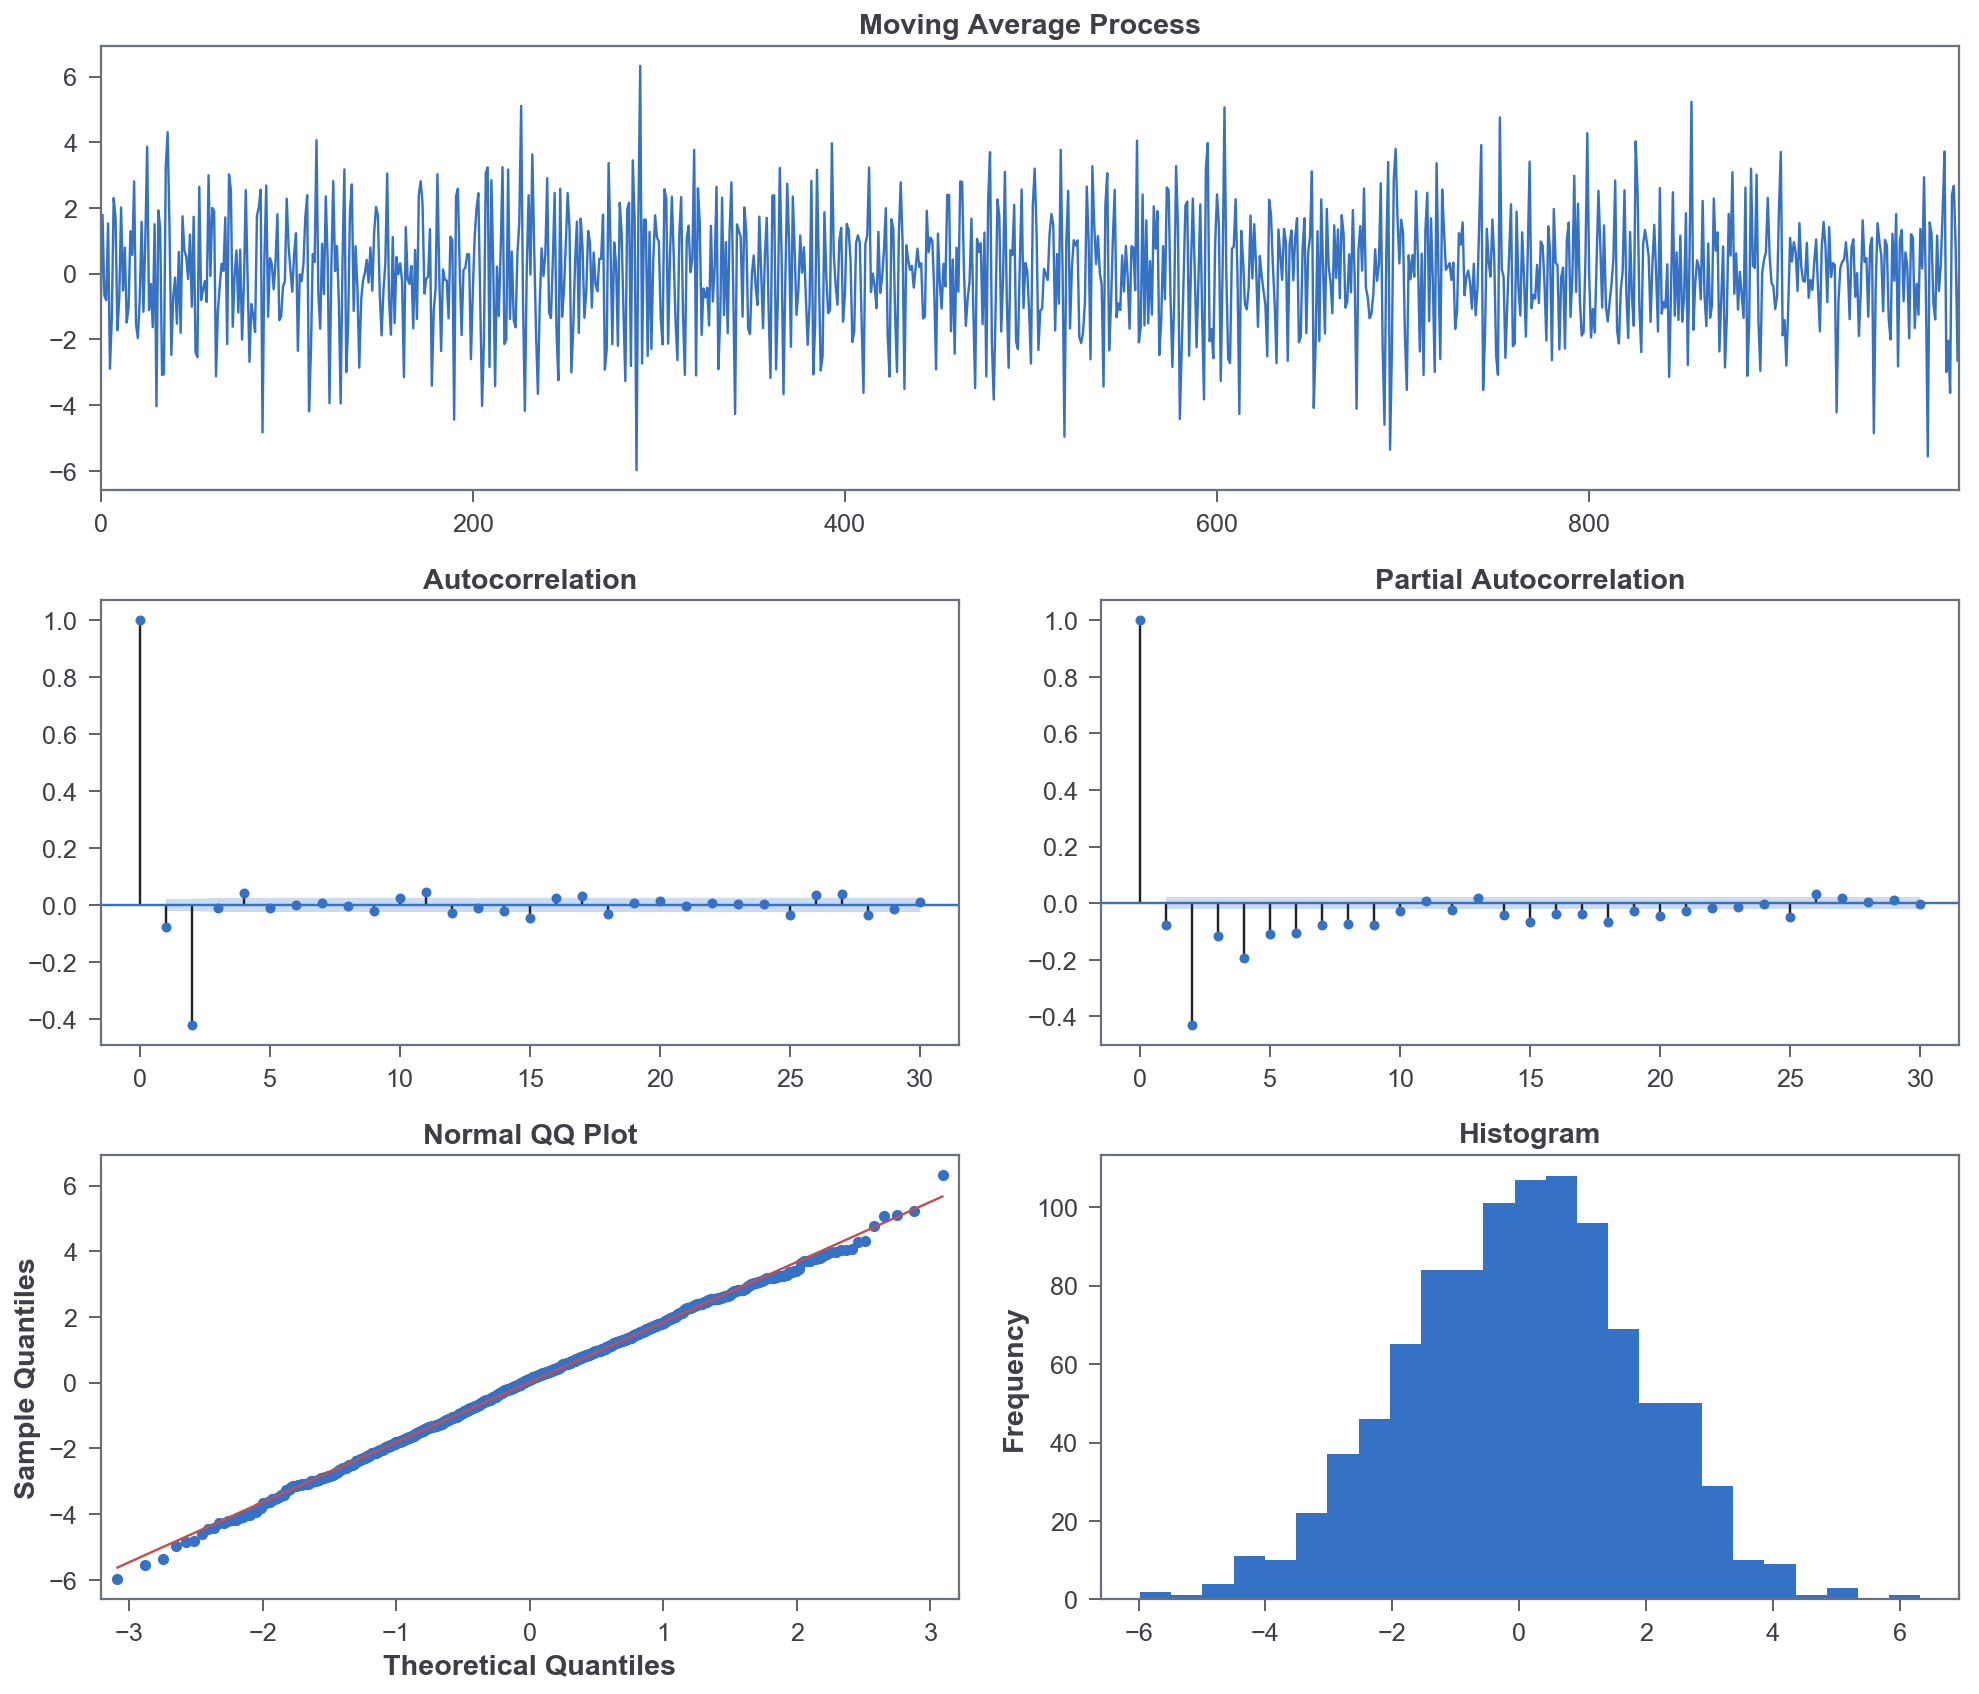

In [25]:
np.random.seed(4)

# parameter setting
T = 1000
e = np.random.normal(size=T)
x = np.zeros_like(e)
theta1 = 0.8
theta2 = - 1.4

# simulate MA(2)
for t in range(T):
    x[t] = e[t] + theta1 * e[t-1] + theta2 * e[t-2]

    # plot series
ts_plot(x, lags=30, filename='ma2', title='Moving Average Process')

## 2.8 Exercise

Generate data from an ARMA(2, 1) process of your choice with formula

$$
x_t = \mu + \phi_1 x_{t-1} + \phi_2 x_{t-2} + \varepsilon_t + \theta_1 \varepsilon_{t-1}
$$

where $\mu$ is the general level of the time series. To get you started use

In [11]:
np.random.seed(23787)

# define parameters
T =
mu =
phi1 =
phi2 =
theta1 = 
e = np.random.normal(T)
x = np.zeros_like(e)

# simulate series
for t in range(T):
    x[t] = 

#plot series


SyntaxError: invalid syntax (<ipython-input-11-74e1da4561d9>, line 4)

Calcualte summary statistics. For example use <code>?x</code> to find out what you can do with this object. Analyse the statistical properties of this series

Import the data set <code>stock_data</code> and have a lookt at it. Plot the data using <code>ts_plot</code>. Does this curve remind you of something?